<a href="https://colab.research.google.com/github/heeboy007/AzureOTTSolver/blob/master/notebooks/03_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

일단 피드백 대로 싱글몰트 카테고리만 추가적으로 더 도수에 따라서 카테고리를 나누었으며, 그것에 따라서 성능 측정을 할 계획입니다.
Colab을 이용 중이라고 하시면 content안에 미리 빌드된 파일을 넣거나, drive에 연결할때 까지 기다리면 됩니다.

### Data Split

In [1]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PACK_PATH = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    DATA_DIR = Path('/content/unpacked')

    # unzip 실행
    !mkdir -p /content/unpacked
    !unzip -q "/content/drive/My Drive/colab_drive/prepacked.zip" -d "/content/unpacked"
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

Mounted at /content/drive


PosixPath('/content/unpacked')

In [2]:
import re
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_recategorized.csv'
IMAGE_SIZE = (256, 256)
RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

In [3]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2943 [00:00<?, ?img/s]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# test 분리
X_rest, X_test, y_rest, y_test = train_test_split(
    X, y_int,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_int
)

# train / valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_rest, y_rest,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_rest
)

print("X_train:", X_train.shape)
print("X_valid:", X_valid.shape)
print("X_test :", X_test.shape)

print("y_train 분포:", np.bincount(y_train))
print("y_valid 분포:", np.bincount(y_valid))
print("y_test  분포:", np.bincount(y_test))

print("class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

X_train: (1883, 256, 256, 3)
X_valid: (471, 256, 256, 3)
X_test : (589, 256, 256, 3)
y_train 분포: [316 148  97 468  49 147 155 503]
y_valid 분포: [ 79  37  24 117  12  37  39 126]
y_test  분포: [ 99  46  30 146  15  46  49 158]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Other': 3, 'Rye': 4, 'SM_40_43': 5, 'SM_43_46': 6, 'SM_G46': 7}


In [5]:
X_train = X_train.astype("float32", copy=False)
X_valid = X_valid.astype("float32", copy=False)
X_test = X_test.astype("float32", copy=False)
X_train /= 255;
X_valid /= 255;
X_test /= 255;

In [6]:
print(X_train.shape, y_train.dtype)
print(X_train.shape, y_train[:10])

(1883, 256, 256, 3) int64
(1883, 256, 256, 3) [3 0 0 6 3 6 7 0 3 5]


### Baseline

여기서부터는 강의록2에 있는 코드를 변형한 것입니다.
만약 미리 만들어진 model을 사용하고 싶다면, 아래에 있는 주석을 해제해주시면 되겠습니다.

In [ ]:
MODEL_PATH = DATA_DIR / 'models' / 'model_baseline_v1.keras'
#만약 이미 만들어진 모델을 가져오고 싶으면 이렇게 하면 됩니다.
#model = keras.models.load_model(MODEL_PATH)

In [ ]:
model = keras.Sequential([
    keras.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(300, activation='gelu'),
    layers.Dense(300, activation='gelu'),
    layers.Dense(8, activation='softmax'),
])

In [ ]:
model.compile(optimizer= "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

방법2를 골랐을 경우 128 * 128 * 3을 128 * 256 * 3으로 바꿔주세요

In [ ]:
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=128,
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.2577 - loss: 7.6464 - val_accuracy: 0.2994 - val_loss: 1.7944
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.3416 - loss: 1.7453 - val_accuracy: 0.4225 - val_loss: 1.5967
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.4506 - loss: 1.5906 - val_accuracy: 0.4268 - val_loss: 1.5235
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.4650 - loss: 1.4973 - val_accuracy: 0.4841 - val_loss: 1.4531
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.4656 - loss: 1.4641 - val_accuracy: 0.4544 - val_loss: 1.5070
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.4990 - loss: 1.4035 - val_accuracy: 0.4671 - val_loss: 1.4733
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.5029 - loss: 1.3703 - val_accuracy: 0.4862 - val_loss: 1.5248
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.5282 - loss: 1.2996 - val_accuracy: 0.44

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5959 - loss: 3.3220
0.5959252715110779


In [ ]:
model.save(MODEL_PATH)

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

# classification report 출력
print(classification_report(test_labels, y_pred, target_names=[
    "Blended",
    "Bourbon",
    "Brandy",
    "Other",
    "Rye",
    "SM_40_43",
    "SM_43_46",
    "SM_G46"
]))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
              precision    recall  f1-score   support

     Blended       0.56      0.49      0.52        99
     Bourbon       0.50      0.57      0.53        46
      Brandy       0.73      0.37      0.49        30
       Other       0.76      0.80      0.78       146
         Rye       0.25      0.20      0.22        15
    SM_40_43       0.43      0.28      0.34        46
    SM_43_46       0.43      0.24      0.31        49
      SM_G46       0.57      0.76      0.65       158

    accuracy                           0.60       589
   macro avg       0.53      0.46      0.48       589
weighted avg       0.59      0.60      0.58       589



In [ ]:
#history가 없어진 관계로 수동 복원
train_accuracy = [
    0.3207, 0.4435, 0.4601, 0.4766, 0.4928,
    0.5042, 0.5280, 0.5833, 0.5964, 0.6869,
    0.7247, 0.8105, 0.8653, 0.9002, 0.9482,
    0.9142, 0.9830, 0.9796, 0.9745, 0.9868,
    0.9830, 0.9877, 0.9928, 0.9941, 0.9044,
    0.9949, 0.9970, 0.9966, 0.9966, 0.9609,
    0.9979, 0.9966, 0.9936, 0.9907, 0.9975,
    0.9949, 0.9941, 0.9962, 0.9749, 0.9962,
    0.9987, 0.9979, 0.9953, 0.9894, 0.9796,
    0.9979, 0.9979, 0.9983, 0.9987
]

train_loss = [
    3.1700, 1.6356, 1.5615, 1.4909, 1.4086,
    1.3526, 1.3108, 1.1407, 1.0780, 0.8652,
    0.7648, 0.5292, 0.4242, 0.2971, 0.1674,
    0.3081, 0.0575, 0.0631, 0.0811, 0.0367,
    0.0639, 0.0357, 0.0214, 0.0180, 0.4682,
    0.0265, 0.0093, 0.0116, 0.0079, 0.1585,
    0.0074, 0.0074, 0.0179, 0.0347, 0.0068,
    0.0141, 0.0184, 0.0090, 0.0967, 0.0077,
    0.0032, 0.0033, 0.0150, 0.0394, 0.0786,
    0.0058, 0.0032, 0.0028, 0.0027, 0.0031
]

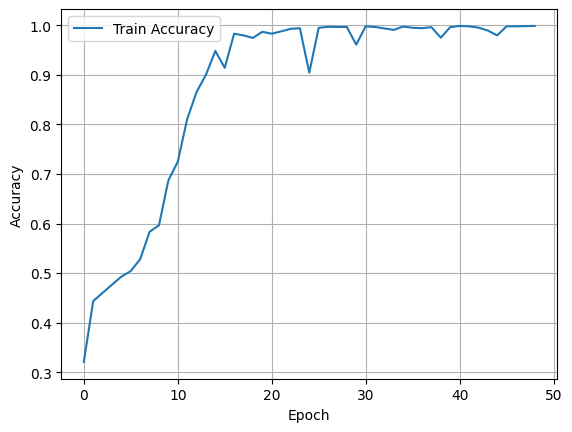

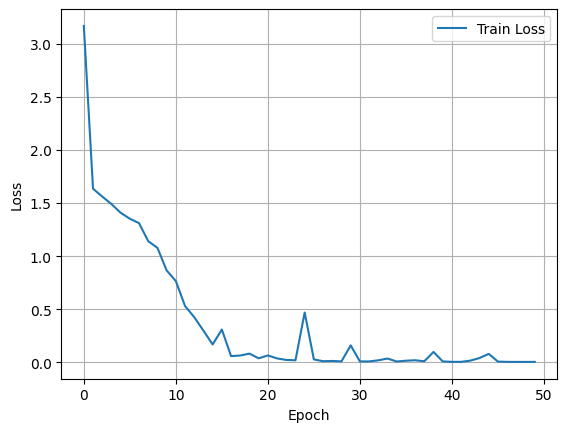

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

plt.plot(train_loss, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### Model Search

In [8]:
CHECK_DIR = DATA_DIR / 'models' / 'chkpoint'

CHECK_DIR.mkdir(parents=True, exist_ok=True)

In [9]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val, start_from_epoch=12, patient=3):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = [] #this is for cumilating f1 per epoch
        self.start_from_epoch = start_from_epoch
        self.patient = patient
        self.out = 0
        self.best_f1 = -1

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred = np.argmax(y_pred, axis=1)

        if self.y_val.ndim == 2:
            y_true = np.argmax(self.y_val, axis=1)
        else:
            y_true = self.y_val

        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        logs['val_macro_f1'] = f1

        if f1 > self.best_f1:
            self.best_f1 = f1

        if 1 < epoch and epoch > self.start_from_epoch and f1 < self.f1_scores[-2]:
            print(f"\nNon Improvement detected at EP : {epoch}, f1 : {f1}")
            self.out += 1

        if self.out >= self.patient:
            print(f"\nStopping at EP : {epoch}, f1 : {f1}")
            self.model.stop_training = True

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.activations import gelu

#the name keyword is just there to use kwargs, it's not actually used.
def build_model(dropout=0.3, use_bn=False, dense_act="relu", name=''):
    act = gelu if dense_act == "gelu" else dense_act

    inputs = keras.Input(shape=(256, 256, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)

    x = layers.Dense(300)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    if dropout >= 0.0:
        x = layers.Dropout(dropout)(x)

    x = layers.Dense(300)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    if dropout >= 0.0:
        x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(8, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

configs = [
    {"name": "gelu_do05", "dropout": 0.5, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_do05_bn", "dropout": 0.5, "use_bn": True, "dense_act": "gelu"},
    {"name": "gelu_do03", "dropout": 0.3, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_do03_bn", "dropout": 0.3, "use_bn": True, "dense_act": "gelu"},
    {"name": "gelu", "dropout": 0.0, "use_bn": False, "dense_act": "gelu"},
    {"name": "gelu_bn", "dropout": 0.0, "use_bn": True, "dense_act": "gelu"},
    {"name": "relu", "dropout": 0.0, "use_bn": False, "dense_act": "relu"},
    {"name": "relu_do01", "dropout": 0.1, "use_bn": False, "dense_act": "relu"},
]

In [ ]:
results = []

for cfg in configs:
    print(f"\n=== Running {cfg['name']} ===")
    curr_model_path = CHECK_DIR / f"last_{cfg['name']}.keras"

    if curr_model_path.exists():
        print(f"[SKIP] {cfg['name']} exists, skipping")
        continue

    model = build_model(**cfg)

    f1_cb = F1ScoreCallback(X_valid, y_valid)

    checkpoint = ModelCheckpoint(
        CHECK_DIR / f"chk_{cfg['name']}.keras",
        monitor='val_macro_f1',
        save_best_only=True,
        mode='max'
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=30,
        batch_size=128,
        callbacks=[f1_cb, checkpoint],
        verbose=1
    )

    model.save(curr_model_path)

    best_f1 = max(f1_cb.f1_scores)
    results.append((cfg["name"], best_f1))
    print(f"{cfg['name']} best val_macro_f1 = {best_f1:.4f}")


=== Running gelu_do05 ===
Epoch 1/30
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2421 - loss: 2.9386

KeyboardInterrupt: 

In [12]:
cv_results = []

In [13]:
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score
from tensorflow.keras.backend import clear_session

# ----- 설정 값들 -----
N_SPLITS   = 5      # k-fold 개수
EPOCHS     = 30     # 최대 epoch
BATCH_SIZE = 64
CONFIG_INDEX = 7

# X_rest, y_rest 가 이미 있다고 가정 (test는 따로 빼둔 상태)
# configs 와 build_model(dropout, use_bn, dense_act) 도 있다고 가정

skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

cfg = configs[CONFIG_INDEX]
name = cfg["name"]
print(f"\n===== K-Fold CV for config: {name} =====")

fold_losses     = []
fold_accuracies = []
fold_precisions = []
fold_f1s        = []
fold_last_f1s   = []

# k-fold 루프
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_rest, y_rest), start=1):
    print(f"\n[{name}] Fold {fold_idx}/{N_SPLITS}")

    X_tr, X_val = X_rest[train_idx], X_rest[val_idx]
    y_tr, y_val = y_rest[train_idx], y_rest[val_idx]

    clear_session()

    # 모델 생성(컴파일도 여기서 진행!)
    model = build_model(**cfg)

    # 대체
    f1_cb = F1ScoreCallback(X_val, y_val)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[f1_cb],
        verbose=1,   # 필요하면 1로 바꿔도 됨
    )

    # ---- 이 fold에서 metrics 계산 ----
    # 1) loss / accuracy (evaluate)
    loss, acc = model.evaluate(X_val, y_val, verbose=0)

    # 2) 예측값 가져와서 precision / f1 (macro) 계산
    y_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # y_val은 이미 정수 레이블이라고 가정 (LabelEncoder 사용)
    y_true = y_val

    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    f1        = f1_cb.best_f1
    last_f1   = f1_cb.f1_scores[-1]

    fold_losses.append(loss)
    fold_accuracies.append(acc)
    fold_precisions.append(precision)
    fold_f1s.append(f1)
    fold_last_f1s.append(last_f1)

    print(f"[{name}] Fold {fold_idx}: "
          f"loss={loss:.4f}, acc={acc:.4f}, "
          f"prec_macro={precision:.4f}, f1_macro={f1:.4f}")

    del model
    model = None
    gc.collect()

# ----- config별 평균/표준편차 정리 -----
cfg_row = {
    "name": name,
    "dropout": cfg["dropout"],
    "use_bn": cfg["use_bn"],
    "dense_act": cfg["dense_act"],
    "loss_mean": float(np.mean(fold_losses)),
    "loss_std":  float(np.std(fold_losses)),
    "acc_mean":  float(np.mean(fold_accuracies)),
    "acc_std":   float(np.std(fold_accuracies)),
    "prec_macro_mean": float(np.mean(fold_precisions)),
    "prec_macro_std":  float(np.std(fold_precisions)),
    "best_f1_macro_mean":   float(np.mean(fold_f1s)),
    "best_f1_macro_std":    float(np.std(fold_f1s)),
    "last_f1_macro_mean":   float(np.mean(fold_last_f1s)),
    "last_f1_macro_std":    float(np.std(fold_last_f1s)),
}

print(f"\n>>> [CV Summary] {name}: "
      f"f1_macro={cfg_row['best_f1_macro_mean']:.4f} ± {cfg_row['best_f1_macro_std']:.4f}, "
      f"last_f1_macro={cfg_row['last_f1_macro_mean']:.4f} ± {cfg_row['last_f1_macro_std']:.4f}, "
      f"acc={cfg_row['acc_mean']:.4f} ± {cfg_row['acc_std']:.4f}, "
      f"loss={cfg_row['loss_mean']:.4f} ± {cfg_row['loss_std']:.4f}")

cv_results.append(cfg_row)


===== K-Fold CV for config: relu_do01 =====

[relu_do01] Fold 1/5
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 566ms/step - accuracy: 0.2025 - loss: 353.0753 - val_accuracy: 0.3928 - val_loss: 1.8734 - val_macro_f1: 0.1606
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.4835 - loss: 1.5842 - val_accuracy: 0.4183 - val_loss: 1.7342 - val_macro_f1: 0.2740
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.6028 - loss: 1.1956 - val_accuracy: 0.4692 - val_loss: 1.9206 - val_macro_f1: 0.3073
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.6996 - loss: 0.9090 - val_accuracy: 0.4586 - val_loss: 1.9590 - val_macro_f1: 0.3475
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7671 - loss: 0.6910 - val_accuracy: 0.4628 - val_loss: 2.1640 - val_macro_f1: 0.3255
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8097 - loss: 0.5836 - val_accuracy: 0.4904 - val_loss: 2.1836 - val_macro_f1: 0.3845
Epoch 7/30
30/30 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
# ----- 전체 config 결과를 테이블로 보기 -----
cv_df = pd.DataFrame(cv_results).sort_values("best_f1_macro_mean", ascending=False)
print("\n===== K-Fold 결과 (정렬: best_f1_macro_mean 내림차순) =====")
print(cv_df.to_string(index=False))

kfold_result_csv_path = DATA_DIR / "kfold_result_2.csv"

cv_df.to_csv(kfold_result_csv_path)


===== K-Fold 결과 (정렬: best_f1_macro_mean 내림차순) =====
   name  dropout  use_bn dense_act  loss_mean  loss_std  acc_mean  acc_std  prec_macro_mean  prec_macro_std  best_f1_macro_mean  best_f1_macro_std  last_f1_macro_mean  last_f1_macro_std
gelu_bn      0.0    True      gelu   1.916293  0.369105  0.582415 0.035134         0.523458        0.038630            0.494050           0.016185            0.450844           0.056420
   gelu      0.0   False      gelu   3.852971  0.650101  0.517406 0.021464         0.427175        0.025686            0.430416           0.030402            0.387274           0.027722
   relu      0.0   False      relu   4.042616  0.541877  0.501709 0.018951         0.414351        0.040631            0.416206           0.024500            0.395115           0.030738
